In [84]:
import os
import random

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
import keras.backend as K

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping


from skimage.morphology import label, binary_opening, disk
from skimage.io import imread
from skimage.transform import resize

In [2]:
#path to data
TRAIN_FOLDER = 'data/train_v2/'
MODEL_WEIGHTS_PATH = 'models_weigths/'

#Validation dataset size
VALID_SIZE = 0.1

#Training parameters
N_EPOCHS = 10
BATCH_SIZE = 32
IMAGE_RESIZE = (256, 256)

#random seed
RANDOM_SEED = 42

In [3]:
#defs for decode and encode our masks of ships (Yeap, i took it from kaggle)

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

In [4]:
#masks of ships per image
df = pd.read_csv('data/train_ship_segmentations_v2.csv')

#count number of ships as new dataframe
num_of_ships = df.groupby('ImageId')['EncodedPixels'].count().rename("Num_of_ships").reset_index()

#select images with no target and with targets for different splitting
imgs_0 = num_of_ships[num_of_ships['Num_of_ships']==0].copy().reset_index(drop=True)
imgs_1 = num_of_ships[num_of_ships['Num_of_ships']>0].copy().reset_index(drop=True)

In [5]:
#split images with ships with stratifying by number of ships
train_filenames, valid_filenames = train_test_split(
    imgs_1['ImageId'].values, 
    test_size=VALID_SIZE, 
    stratify=imgs_1['Num_of_ships'],
    random_state=RANDOM_SEED
)

In [6]:
#count mean value of all channels(RGB)
channels_mean = []

for img_name in imgs_0['ImageId'].values:
    
    try:
        img = imread(os.path.join(TRAIN_FOLDER, img_name))
        channels_mean.append(np.mean(img))
    except:
        channels_mean.append(0)
        
imgs_0['channels_mean'] = channels_mean
#round mean values 
imgs_0 = imgs_0.copy().round()

#def to split images into the classes by color channels mean
def channel_class(x):
    for i in range(6):
        if x < (i+1)*50:
            return i
        else:
            pass
        
imgs_0['class'] = imgs_0['channels_mean'].apply(lambda x: channel_class(x))

In [7]:
#imgs_0 = pd.read_csv('imgs_0.csv', index_col=0)

In [8]:
#split images with no ships with stratifying by class of color gamma to undersample
_, train_filenames_0, _, classes_0 = train_test_split(
    imgs_0['ImageId'].values, imgs_0['class'].values,
    test_size=VALID_SIZE, 
    stratify=imgs_0['class'],
    random_state=RANDOM_SEED
)

train_filenames_0, valid_filenames_0 = train_test_split(
    train_filenames_0,
    test_size=VALID_SIZE, 
    stratify=classes_0,
    random_state=RANDOM_SEED
)

In [9]:
#concatenate images with ships and without and shuffle
random.seed(RANDOM_SEED)

train_filenames = np.concatenate((train_filenames, train_filenames_0))
random.shuffle(train_filenames)

valid_filenames = np.concatenate((valid_filenames, valid_filenames_0))
random.shuffle(valid_filenames)

In [10]:
print('Train sample size: ', train_filenames.shape)
print('Valid sample size: ', valid_filenames.shape)

Train sample size:  (51800,)
Valid sample size:  (5756,)


# Data generator and Augmentation

In [11]:
#Data generator for images

class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, data_frame=None, batch_size=BATCH_SIZE, image_size=IMAGE_RESIZE, shuffle=True, predict=False, augment=False):
        self.folder = folder
        self.filenames = filenames
        self.data_frame = data_frame
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.predict = predict
        self.augment = augment
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load jpg file as numpy array
        img = imread(os.path.join(self.folder, filename))
        # create empty mask
        msk = masks_as_image(self.data_frame.query('ImageId==@filename')['EncodedPixels'])
        
        img = resize(img.astype(np.float32), self.image_size, mode='reflect')/255.0     
        msk = resize(msk.astype(np.float32), self.image_size, mode='reflect')
        
        #Image Augmentation
        if self.augment:
            d = np.random.choice([{'zx': 1,
                                   'zy': 1,
                                   'flip_horizontal': False,
                                   'flip_vertical': True},
                                  {'zx': 0.9,
                                   'zy': 0.9,
                                   'flip_horizontal': False,
                                   'flip_vertical': False},
                                  None,
                                  {'zx': 1,
                                   'zy': 1,
                                   'flip_horizontal': True,
                                   'flip_vertical': True},
                                  {'theta': 0,
                                   'zx': 1.1,
                                   'zy': 1.1,
                                   'flip_horizontal': True,
                                   'flip_vertical': False},
                                 ])
            if d:
                img = ImageDataGenerator().apply_transform(img, d)
                msk = ImageDataGenerator().apply_transform(msk, d)
            
        
        return img, msk
    
    def __loadpredict__(self, filename):
        # load jpg file as numpy array
        img = imread(os.path.join(self.folder, filename))
        # resize both image and mask
        img = resize(img.astype(np.float32), self.image_size, mode='reflect')/255.0 
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [12]:
#Train and valid data generators
train_gen = generator(TRAIN_FOLDER, train_filenames, df, augment=True)
valid_gen = generator(TRAIN_FOLDER, valid_filenames, df)

# Model U-Net architecture

In [13]:
def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    # upsample
    x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = tf.keras.layers.concatenate([x, conv_features])
    # dropout
    x = tf.keras.layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

In [14]:
inputs = tf.keras.layers.Input((IMAGE_RESIZE[0], IMAGE_RESIZE[1], 3))

# encoder: contracting path - downsample
# 1 - downsample
f1, p1 = downsample_block(inputs, 32)
# 2 - downsample
f2, p2 = downsample_block(p1, 64)
# 3 - downsample
f3, p3 = downsample_block(p2, 128)
# 4 - downsample
f4, p4 = downsample_block(p3, 256)
# 5 - bottleneck
bottleneck = double_conv_block(p4, 512)
# decoder: expanding path - upsample
# 6 - upsample
u6 = upsample_block(bottleneck, f4, 256)
# 7 - upsample
u7 = upsample_block(u6, f3, 128)
# 8 - upsample
u8 = upsample_block(u7, f2, 64)
# 9 - upsample
u9 = upsample_block(u8, f1, 32)
# outputs
outputs = tf.keras.layers.Conv2D(1, 1, padding="same", activation = "sigmoid")(u9)

unet_model = tf.keras.Model(inputs=[inputs], outputs=[outputs], name="U-Net")

2024-02-20 10:27:32.001604: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-20 10:27:32.001628: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-20 10:27:32.001633: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-20 10:27:32.001659: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-20 10:27:32.001671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

                                                                                                  
 concatenate_3 (Concatenate  (None, 256, 256, 64)         0         ['conv2d_transpose_3[0][0]',  
 )                                                                   'conv2d_1[0][0]']            
                                                                                                  
 dropout_7 (Dropout)         (None, 256, 256, 64)         0         ['concatenate_3[0][0]']       
                                                                                                  
 conv2d_16 (Conv2D)          (None, 256, 256, 32)         18464     ['dropout_7[0][0]']           
                                                                                                  
 conv2d_17 (Conv2D)          (None, 256, 256, 32)         9248      ['conv2d_16[0][0]']           
                                                                                                  
 conv2d_18

In [16]:
#dice coefficient implementation
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

#loss for model 0.2*binary_crossentropy+ 0.8*(1 - dice_coef)
def bce_dice_coef_loss(y_true, y_pred, smooth=1):
    return 0.2*binary_crossentropy(y_true, y_pred) + 0.8*(1 - dice_coef(y_true, y_pred, smooth))

#TP rate metric
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)


#Model compile
unet_model.compile(optimizer=Adam(1e-4), 
                   loss=bce_dice_coef_loss, 
                   metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [17]:
#add ModelCheckpoint and EarlyStopping callbacks
weight_path="{}_weights_best.h5".format(MODEL_WEIGHTS_PATH+'u_net')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callbacks_list = [checkpoint, early]

In [18]:
#Training model
loss_history = [unet_model.fit(train_gen,
                               epochs=N_EPOCHS, 
                               validation_data=valid_gen,
                               callbacks=callbacks_list
                              )]

Epoch 1/10


2024-02-20 10:27:34.553606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1618/1618 [==============================] - ETA: 0s - loss: 0.4368 - dice_coef: 0.4658 - binary_accuracy: 0.9918 - true_positive_rate: 0.4594
Epoch 1: val_dice_coef improved from -inf to 0.59942, saving model to models_weigths/u_net_weights_best.h5
1618/1618 [==============================] - 5033s 3s/step - loss: 0.4368 - dice_coef: 0.4658 - binary_accuracy: 0.9918 - true_positive_rate: 0.4594 - val_loss: 0.3253 - val_dice_coef: 0.5994 - val_binary_accuracy: 0.9949 - val_true_positive_rate: 0.6313
Epoch 2/10
1618/1618 [==============================] - ETA: 0s - loss: 0.3060 - dice_coef: 0.6244 - binary_accuracy: 0.9949 - true_positive_rate: 0.6052
Epoch 2: val_dice_coef improved from 0.59942 to 0.65899, saving model to models_weigths/u_net_weights_best.h5
1618/1618 [==============================] - 5549s 3s/step - loss: 0.3060 - dice_coef: 0.6244 - binary_accuracy: 0.9949 - true_positive_rate: 0.6052 - val_loss: 0.2768 - val_dice_coef: 0.6590 - val_binary_accuracy: 0.9955 - val_tru

In [19]:
#unet_model.save_weights('unet_weights_last.h5')

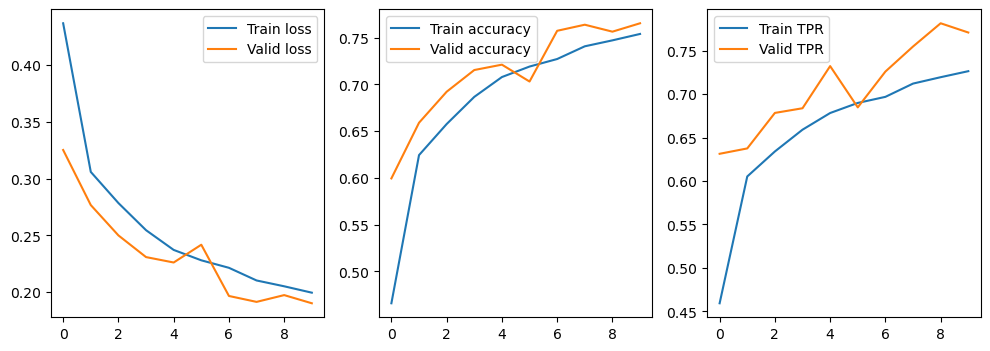

In [33]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(loss_history[0].epoch, loss_history[0].history["loss"], label="Train loss")
plt.plot(loss_history[0].epoch, loss_history[0].history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(loss_history[0].epoch, loss_history[0].history["dice_coef"], label="Train accuracy")
plt.plot(loss_history[0].epoch, loss_history[0].history["val_dice_coef"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(loss_history[0].epoch, loss_history[0].history["true_positive_rate"], label="Train TPR")
plt.plot(loss_history[0].epoch, loss_history[0].history["val_true_positive_rate"], label="Valid TPR")
plt.legend()
plt.show()

# Submission

In [20]:
for t_x, t_y in valid_gen:
    break

In [21]:
preds = unet_model.predict(t_x)

1/1 [==============================] - 0s 377ms/step


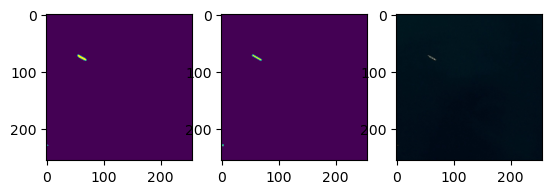

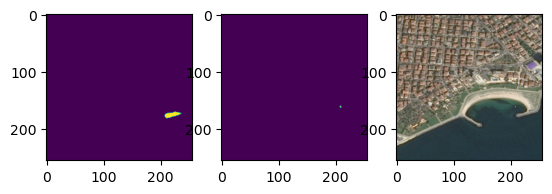

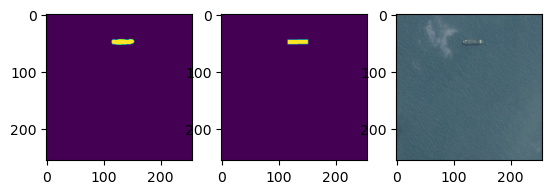

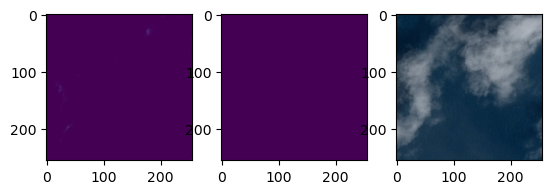

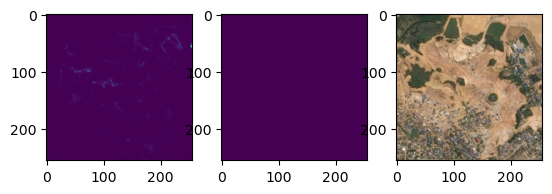

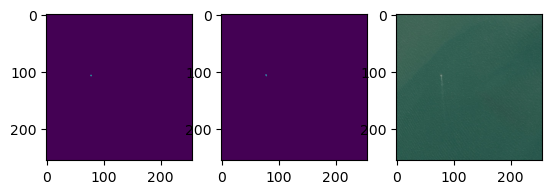

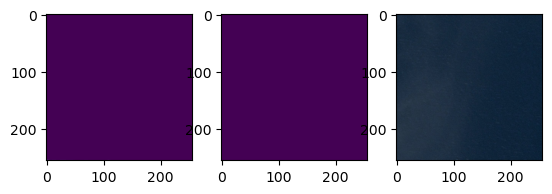

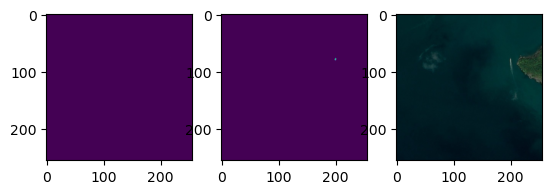

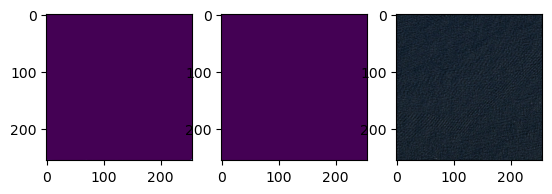

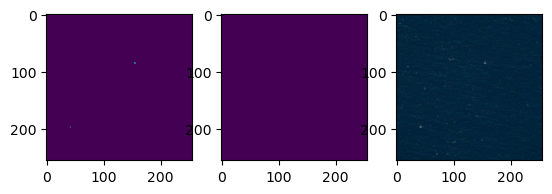

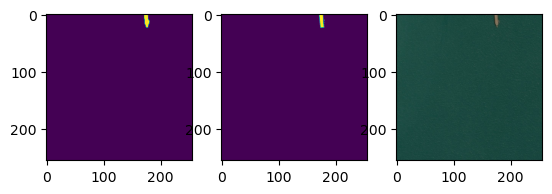

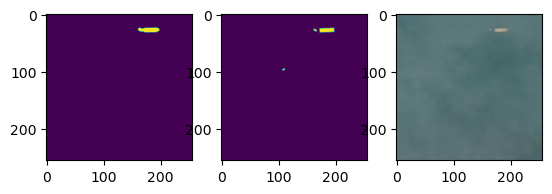

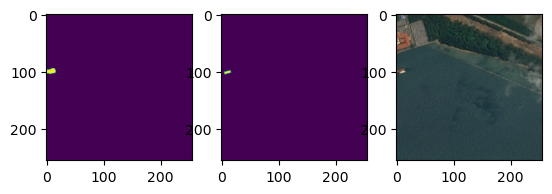

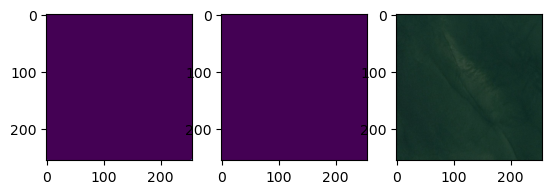

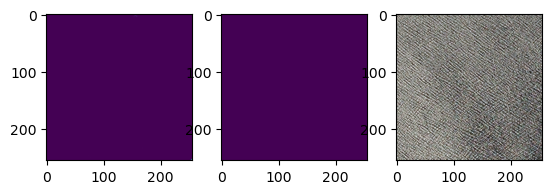

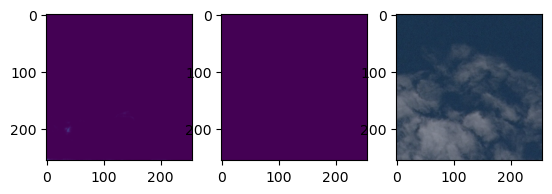

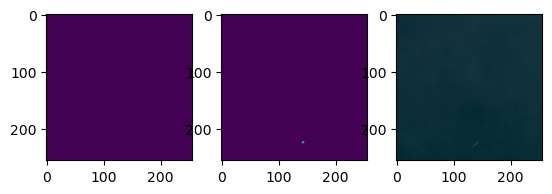

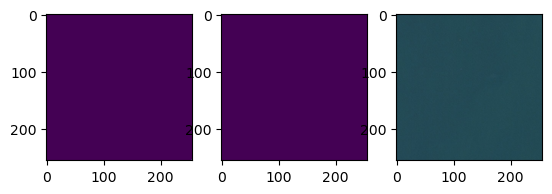

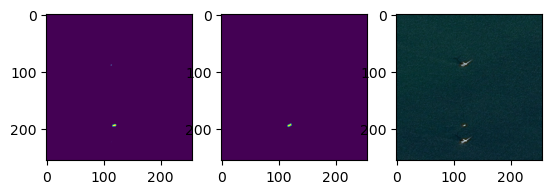

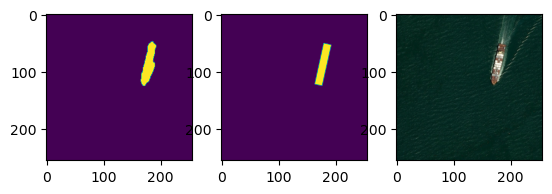

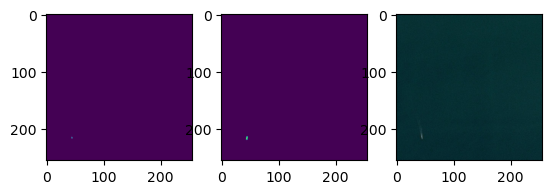

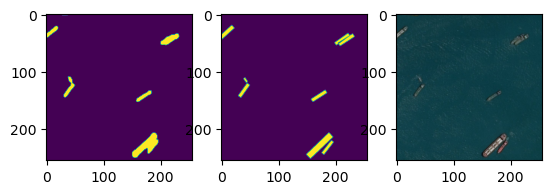

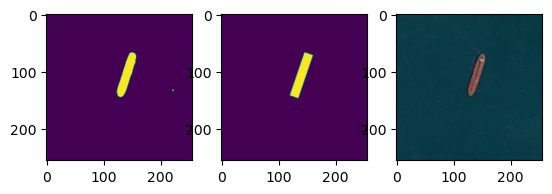

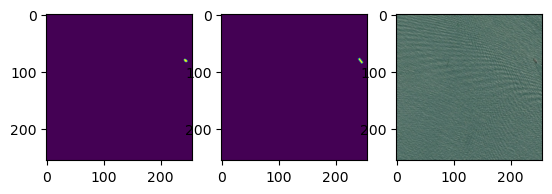

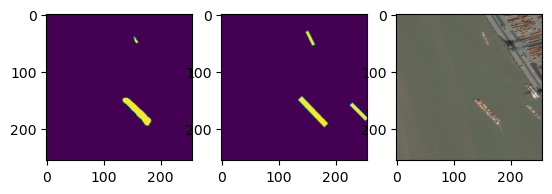

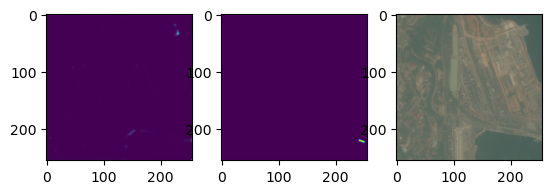

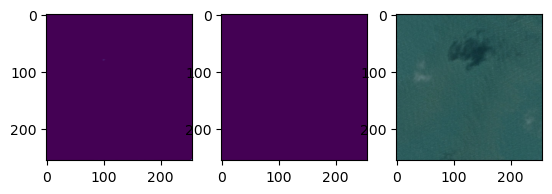

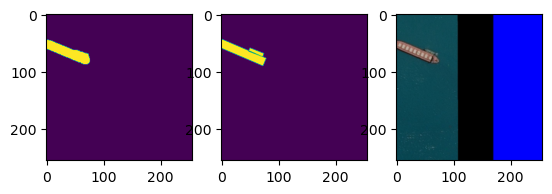

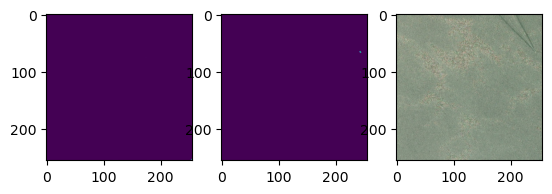

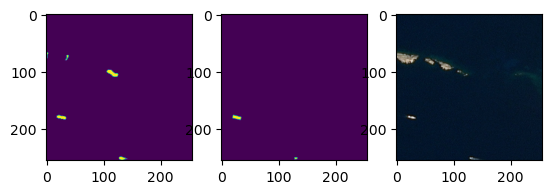

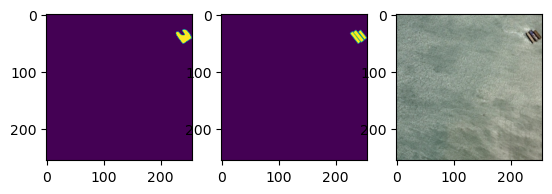

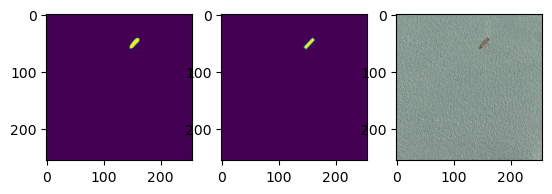

In [30]:

for i in range(32):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(preds[i])
    axs[1].imshow(t_y[i])
    axs[2].imshow(t_x[i])
    plt.show()

In [35]:
preds[0]

(256, 256, 1)

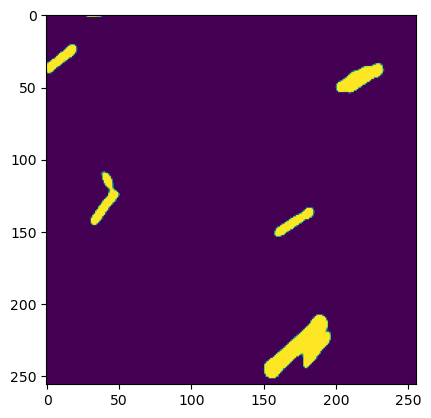

In [83]:
plt.imshow(preds[21])

In [71]:
cur_seg = preds[21]

In [72]:
from skimage.morphology import binary_opening, disk

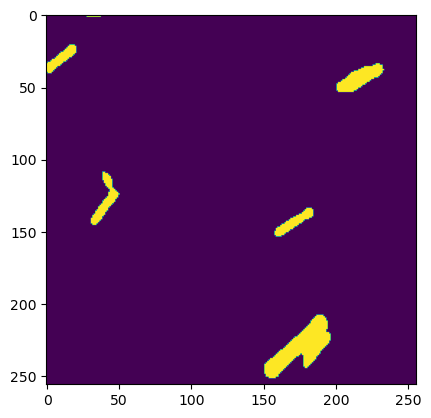

In [80]:
plt.imshow((cur_seg>0.5).astype(np.int32))

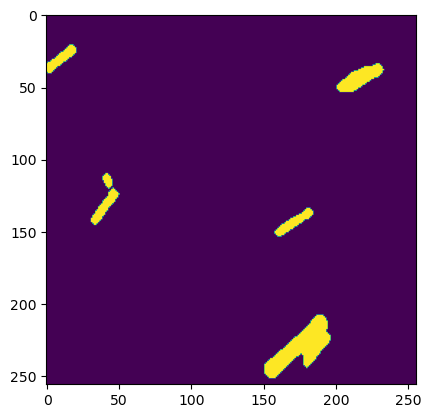

In [81]:
plt.imshow(binary_opening(cur_seg>0.5, np.expand_dims(disk(2), -1)).astype(np.int32))